# Biological Network of Protein-Protein Interactions (PPIs) 

## Objective 

The primary objective of this project is to analyze and extract meaningful insights from a protein-protein interaction (PPI) network using computational tools, specifically the Python library NetworkX. It bridges computational techniques and biological systems to better understand how proteins interact within a biological context, which can reveal critical insights into cellular processes, disease mechanisms, and drug targets.








## Table of Contents
1. [Data Preparation](#datapreparation)
2. [Graph Construction and Representation](#graph-construction)
3. [Path Analysis](#path)
4. [Connectivity Analysis](#connectivity)
5. [Network-Level Insights](#network-level)
6. [Conclusion](#conclusion)





<a id='datapreparation'></a>
## 1. Data Preparation

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Show Data Overview (Old Method)
print("Dataset Overview:")
from IPython.display import display
display(ppi_data.head())  # Display the first few rows of the dataset
total_samples = ppi_data.shape[0]  # Total number of rows
print(f"\nTotal Number of Samples in the Dataset: {total_samples}")

# Step 3: Check for duplicates
duplicates = ppi_data.duplicated()
duplicate_count = duplicates.sum()

# Display duplicate count
duplicate_data = pd.DataFrame({"Metric": ["Number of Duplicate Rows"], "Value": [duplicate_count]})
display(duplicate_data)

# If duplicates exist, display the rows
if duplicate_count > 0:
    print("\nDuplicate Rows:")
    display(ppi_data[duplicates])

# Step 4: Check for missing values
missing_values = ppi_data.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display missing values as a table
print("\nMissing Values in Dataset:")
display(missing_values.style.background_gradient(cmap="Reds"))

# Step 5: Check unique values in 'Source' and 'Target' columns
unique_source = set(ppi_data['Source'].unique())  # Unique tail nodes
unique_target = set(ppi_data['Target'].unique())  # Unique head nodes

# Find common nodes between Source and Target
common_nodes = unique_source.intersection(unique_target)  # Common nodes
common_nodes_count = len(common_nodes)

# Display unique counts and common nodes as a final table
final_counts = pd.DataFrame({
    "Metric": ["Unique Tail Nodes (Source)", "Unique Head Nodes (Target)", "Common Nodes"],
    "Count": [len(unique_source), len(unique_target), common_nodes_count]
})
display(final_counts)

# Display a sample of common nodes
if common_nodes_count > 0:
    common_nodes_sample = pd.DataFrame({"Common Nodes (Sample)": list(common_nodes)[:10]})
    print("\nSample Common Nodes:")
    display(common_nodes_sample)
else:
    print("\nNo common nodes between Source and Target.")

# Step 6: Histogram for interaction counts
# Count the occurrences of each protein in both Source and Target columns
interaction_counts = pd.concat([ppi_data['Source'], ppi_data['Target']]).value_counts()

# Separate the top 10 and bottom 10 proteins
top_10_interactions = interaction_counts.head(10)
bottom_10_interactions = interaction_counts.tail(10)

# Plot two histograms as subplots
plt.figure(figsize=(14, 8))

# Top 10 interactions
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_interactions.values, y=top_10_interactions.index, palette="Blues_d")
plt.title('Top 10 Proteins by Interaction Count', fontsize=16)
plt.xlabel('Interaction Count', fontsize=14)
plt.ylabel('Protein', fontsize=14)

# Bottom 10 interactions
plt.subplot(1, 2, 2)
sns.barplot(x=bottom_10_interactions.values, y=bottom_10_interactions.index, palette="Reds_d")
plt.title('Bottom 10 Proteins by Interaction Count', fontsize=16)
plt.xlabel('Interaction Count', fontsize=14)
plt.ylabel('Protein', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Find unique and uncommon proteins
unique_source = set(ppi_data['Source'].unique())  # Unique tail nodes
unique_target = set(ppi_data['Target'].unique())  # Unique head nodes

# Uncommon proteins
source_only = unique_source - unique_target  # Proteins exclusive to Source
target_only = unique_target - unique_source  # Proteins exclusive to Target

# Step 3: Count Tail-only and Head-only Proteins
tail_only_count = len(source_only)
head_only_count = len(target_only)

# Display the counts
print(f"Number of Tail-only Proteins: {tail_only_count}")
print(f"Number of Head-only Proteins: {head_only_count}")

# Step 4: Combine and label the results
uncommon_proteins = pd.DataFrame({
    "Protein": list(source_only) + list(target_only),
    "Exclusivity": ["Tail-only"] * len(source_only) + ["Head-only"] * len(target_only)
})

# Display the first few rows of uncommon proteins
print("\nUncommon Proteins:")
from IPython.display import display
display(uncommon_proteins)  # Show a sample of 20 uncommon proteins


<a id='graph-construction'></a>
## 2. Graph Construction

In [ ]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import random

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in ppi_data.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Edge_Weight'])

# Step 3: Sample edges and check nodes
# Randomly sample 10 edges from the graph
sample_edges = random.sample(list(G.edges(data=True)), 10)
sample_nodes = set([edge[0] for edge in sample_edges] + [edge[1] for edge in sample_edges])  # Collect nodes

# Check if nodes are in the original dataset
node_checks = {node: (node in ppi_data['Source'].values or node in ppi_data['Target'].values) for node in sample_nodes}

# Step 4: Prepare data for visualization
# Generate positions for nodes
pos = nx.spring_layout(G, seed=42)

# Extract edge data for visualization
edge_x, edge_y, edge_text = [], [], []
for edge in sample_edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(f"{edge[0]} → {edge[1]}<br>Weight: {edge[2]['weight']}")

# Create edge traces for Plotly
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='text',
    mode='lines',
    text=edge_text
)

# Extract node data
node_x, node_y, node_text = [], [], []
for node in sample_nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>In Data: {node_checks[node]}")

# Create node traces for Plotly
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    hoverinfo='text',
    marker=dict(
        size=10,
        color='#1f77b4'
    )
)

# Step 5: Visualize with Plotly
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Sample Edges Visualization",
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )
)

fig.show()


In [ ]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import random

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in ppi_data.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Edge_Weight'])

# Step 3: Sample edges and check nodes
# Randomly sample 10 edges from the graph
sample_edges = random.sample(list(G.edges(data=True)), 10)
sample_nodes = set([edge[0] for edge in sample_edges] + [edge[1] for edge in sample_edges])  # Collect nodes

# Check if nodes are in the original dataset
node_checks = {node: (node in ppi_data['Source'].values or node in ppi_data['Target'].values) for node in sample_nodes}

# Check for reverse edges in the original dataset
reverse_edge_checks = []
for edge in sample_edges:
    tail, head = edge[0], edge[1]
    reverse_exists = ((ppi_data['Source'] == head) & (ppi_data['Target'] == tail)).any()
    reverse_edge_checks.append((tail, head, reverse_exists))

# Step 4: Prepare data for visualization
# Generate positions for nodes
pos = nx.spring_layout(G, seed=42)

# Extract edge data for visualization
edge_x, edge_y, edge_text = [], [], []
edge_weight_x, edge_weight_y, edge_weight_text = [], [], []  # To display edge weights on the plot
for edge, reverse_exists in zip(sample_edges, reverse_edge_checks):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(f"{edge[0]} → {edge[1]}<br>Weight: {edge[2]['weight']}<br>Reverse Exists: {reverse_exists[2]}")
    
    # Compute midpoints for weight labels
    edge_weight_x.append((x0 + x1) / 2)
    edge_weight_y.append((y0 + y1) / 2)
    edge_weight_text.append(f"{edge[2]['weight']:.2f}")

# Create edge traces for Plotly
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1.5, color='#888'),
    hoverinfo='text',
    mode='lines',
    text=edge_text
)

# Create edge weight traces
weight_trace = go.Scatter(
    x=edge_weight_x,
    y=edge_weight_y,
    mode='text',
    text=edge_weight_text,
    hoverinfo='none',
    textfont=dict(
        size=10,
        color='red'
    )
)

# Extract node data
node_x, node_y, node_text = [], [], []
for node in sample_nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>In Data: {node_checks[node]}")

# Create node traces for Plotly
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    hoverinfo='text',
    marker=dict(
        size=10,
        color='#1f77b4'
    )
)

# Step 5: Visualize with Plotly
fig = go.Figure(
    data=[edge_trace, weight_trace, node_trace],
    layout=go.Layout(
        title="Sample Edges Visualization with Edge Weights",
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )
)

fig.show()


In [ ]:

# Retrieve the corresponding edges from the original dataset
sample_edges_df = pd.DataFrame(
    [(edge[0], edge[1], edge[2]['weight']) for edge in sample_edges],
    columns=['Source', 'Target', 'Edge_Weight']
)

# Match the sampled edges with the dataset
matched_edges = ppi_data.merge(sample_edges_df, on=['Source', 'Target', 'Edge_Weight'], how='inner')

# Display the matched edges for verification
print("\nSampled Edges from Graph:")
display(sample_edges_df)

print("\nMatched Edges in Dataset:")
from IPython.display import display
display(matched_edges)



In [ ]:
# Retrieve the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Display the graph details
print(f"Number of Nodes in the Graph: {num_nodes}")
print(f"Number of Edges in the Graph: {num_edges}")

In [ ]:
# Step 1: Calculate unique nodes in Source (Tail) and Target (Head)
unique_source = set(ppi_data['Source'].unique())  # Unique tail nodes
unique_target = set(ppi_data['Target'].unique())  # Unique head nodes

# Step 2: Find common, tail-only, and head-only nodes
common_nodes = unique_source.intersection(unique_target)  # Common nodes
tail_only_nodes = unique_source - unique_target  # Nodes in tail only
head_only_nodes = unique_target - unique_source  # Nodes in head only

# Step 3: Validate the union
union_nodes = unique_source | unique_target  # Union of Source and Target nodes
calculated_union = common_nodes | tail_only_nodes | head_only_nodes  # Should match union_nodes

# Step 4: Print the results
print(f"Total Nodes in Union (Direct Calculation): {len(union_nodes)}")
print(f"Total Nodes in Union (Sum of Components): {len(calculated_union)}")
print(f"Common Nodes: {len(common_nodes)}")
print(f"Nodes in Tail Only: {len(tail_only_nodes)}")
print(f"Nodes in Head Only: {len(head_only_nodes)}")

# Ensure correctness
assert union_nodes == calculated_union, "The union of nodes does not match the components!"
print("The union matches the sum of its components!")


In [ ]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in ppi_data.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Edge_Weight'])

# Step 3: Generate positions for the full graph (or a subgraph)
pos = nx.spring_layout(G, seed=42)  # Adjust layout for better visualization

# Prepare data for visualization
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Edge trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Node trace
node_x, node_y, node_text = [], [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"Node: {node}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    hoverinfo='text',
    marker=dict(
        size=10,
        color='blue',
        line_width=1
    )
)

# Plotly figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Protein-Protein Interaction Network",
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )
)

fig.show()


## Adjacency Matrix

Unweighted adjacency matrix saved to 'unweighted_adjacency_matrix.csv'.


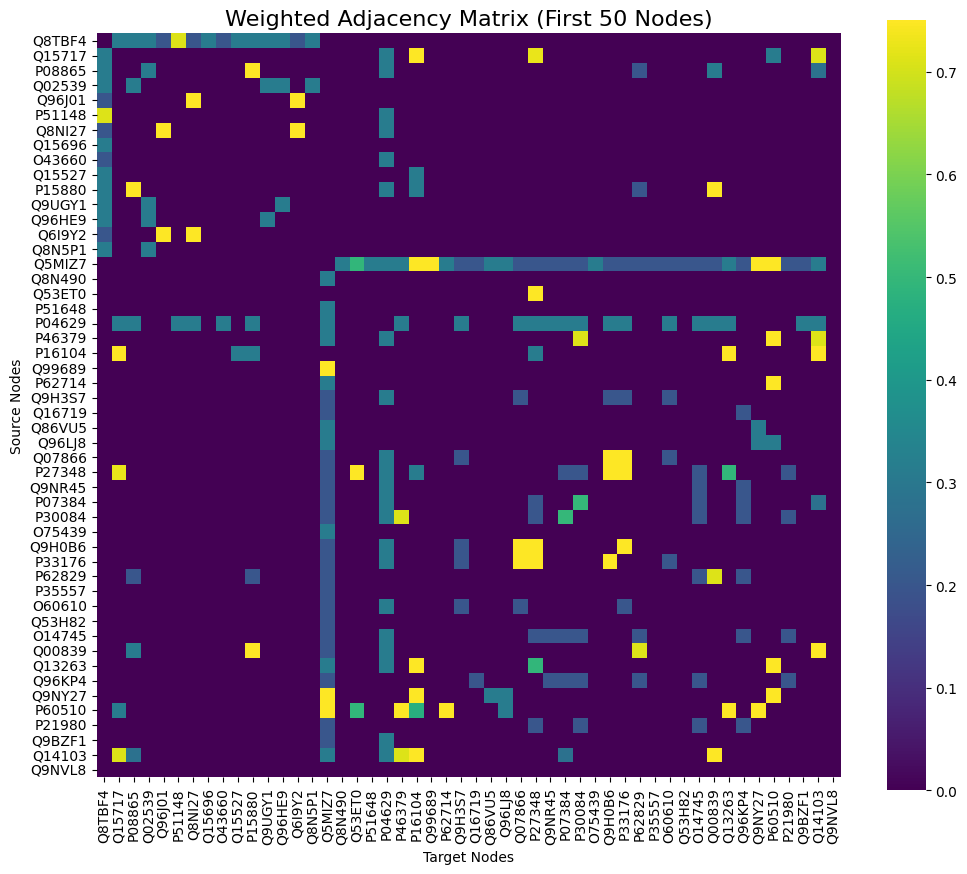

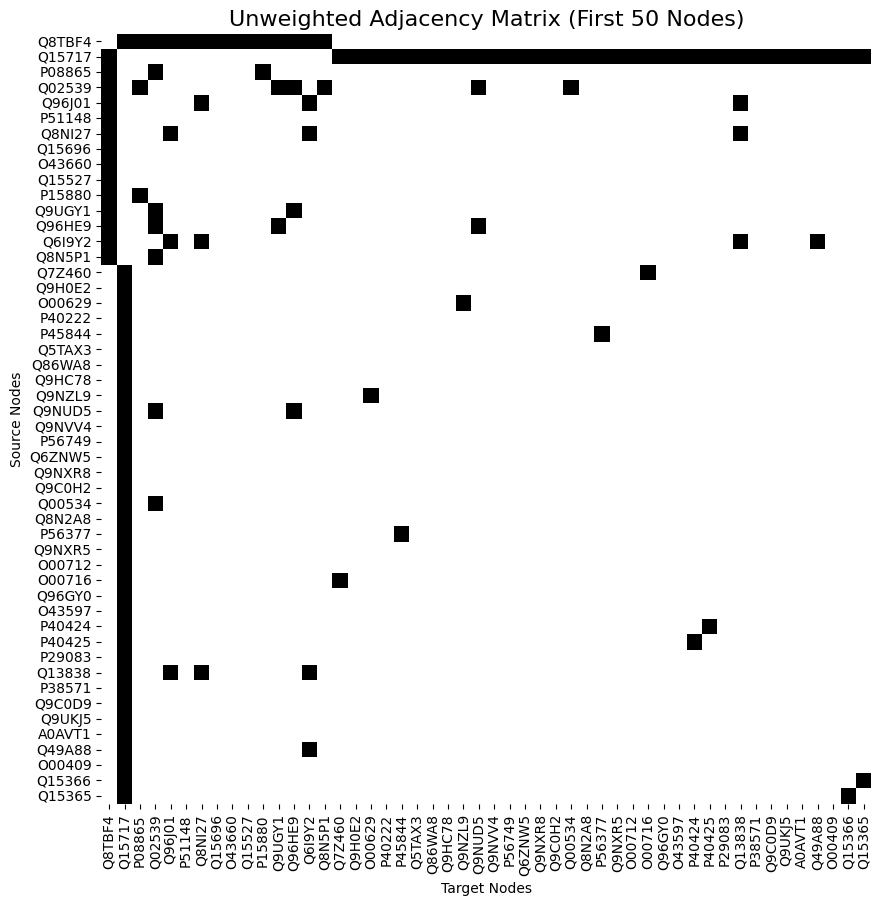

In [1]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data_file = 'PathLinker_2018_human-ppi-weighted-cap0_75.txt'  # Update with your file path
ppi_data = pd.read_csv(data_file, sep='\t', header=1)

# Assign meaningful column names
ppi_data.columns = ['Source', 'Target', 'Edge_Weight', 'Edge_Type']

# Step 2: Create a directed weighted graph
G = nx.DiGraph()

# Add edges with weights
for _, row in ppi_data.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Edge_Weight'])

# Step 3: Create the weighted adjacency matrix
weighted_adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

# Step 4: Convert to an unweighted graph and create the unweighted adjacency matrix
G_unweighted = nx.DiGraph()
for u, v in G.edges():
    G_unweighted.add_edge(u, v)  # Add edges without weights
unweighted_adj_matrix = nx.to_pandas_adjacency(G_unweighted, dtype=int)

# Step 5: Save the unweighted adjacency matrix to a file
unweighted_adj_matrix.to_csv("unweighted_adjacency_matrix.csv")
print("Unweighted adjacency matrix saved to 'unweighted_adjacency_matrix.csv'.")

# Step 6: Visualize the weighted adjacency matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    weighted_adj_matrix.iloc[:50, :50],  # Show the first 50 nodes for clarity
    cmap='viridis',
    cbar=True,
    square=True
)
plt.title("Weighted Adjacency Matrix (First 50 Nodes)", fontsize=16)
plt.xlabel("Target Nodes")
plt.ylabel("Source Nodes")
plt.show()

# Step 7: Visualize the unweighted adjacency matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    unweighted_adj_matrix.iloc[:50, :50],  # Show the first 50 nodes for clarity
    cmap=['white', 'black'],  # Two-color map: white (0), black (1)
    cbar=False,  # Disable the color bar for binary data
    square=True
)
plt.title("Unweighted Adjacency Matrix (First 50 Nodes)", fontsize=16)
plt.xlabel("Target Nodes")
plt.ylabel("Source Nodes")
plt.show()
